# PDE Solution

In [1]:
import torch
from torch import nn
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os

os.makedirs("Data", exist_ok=True)

import requests

url = "https://github.com/maziarraissi/PINNs/raw/master/main/Data/NLS.mat"
r = requests.get(url)

with open("Data/NLS.mat", "wb") as f:
    f.write(r.content)

print("Downloaded NLS.mat to Data/NLS.mat")

Downloaded NLS.mat to Data/NLS.mat


In [4]:
data = scipy.io.loadmat('Data/NLS.mat')

t_np = data['tt'].flatten()[:,None]
x_np = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

In [5]:
t_np.shape, x_np.shape, Exact.shape

((201, 1), (256, 1), (256, 201))

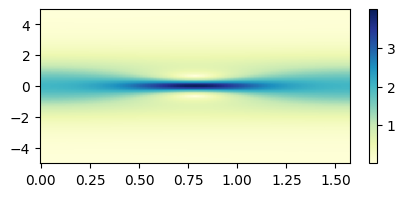

In [6]:
T_np, X_np = np.meshgrid(t_np.squeeze(), x_np.squeeze())

plt.figure(figsize=(5,2))
plt.pcolormesh(T_np, X_np, np.abs(Exact), cmap="YlGnBu")
plt.colorbar()
plt.show()

In [7]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

In [8]:
class Util:
    def __init__(self):
        pass

    def lhs(self, n_samples: int, n_dims: int, dtype=torch.float64, show_plot: bool = False):
        spaces = torch.linspace(0, 1, n_samples + 1, dtype=dtype).to(device)

        # We need to unsqueeze so that we can use broadcasting on the n_dims
        lower_bound = spaces[:-1].unsqueeze(1)
        upper_bound = spaces[1:].unsqueeze(1)

        rand_idx = torch.rand(n_samples, n_dims, device=device)
        points = lower_bound + rand_idx * (upper_bound - lower_bound)

        if show_plot:
            self.print_2d_space(points)

        for i in range(n_dims):
            samples_idx = torch.randperm(n_samples, device=device)
            points[:,i] = points[samples_idx,i]

        if show_plot:
            self.print_2d_space(points)

        return points

    def print_2d_space(self, X):
        plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), color='blue', s=50)
        plt.show()

util = Util()

In [9]:
class SchrodingerData:
    def __init__(self, util, Exact, x_np, n_data, n_boundary, n_collocation, t_bound, x_bound):
        # data_points_X = n_data x (t, x)
        # collocation_X = n_data x (t, x)

        # x, t
        X = torch.cat([torch.tensor(x_np, device=device), torch.zeros(size=(x_np.shape[0], 1), device=device)], dim=1)
        rand_data_idx = torch.randint(0, X.shape[0], size=[n_data], device=device)

        self.X_train = X[rand_data_idx]

        Exact = torch.tensor(Exact, device=device)

        real_part = torch.real(Exact[rand_data_idx,0])
        imag_part = torch.imag(Exact[rand_data_idx,0])
        self.y_train = torch.stack([real_part, imag_part], dim=1)


        # x, t
        self.t_boundary = torch.rand(size=(n_boundary,), dtype=torch.float64, device=device) * (t_bound[1] - t_bound[0]) + t_bound[0]
        self.X_low_boundary: torch.tensor = torch.stack([torch.ones(self.t_boundary.shape[0], device=device) * x_bound[0], self.t_boundary.clone()], dim=1)
        self.X_high_boundary: torch.tensor = torch.stack([torch.ones(self.t_boundary.shape[0], device=device) * x_bound[1], self.t_boundary.clone()], dim=1)
        self.X_low_boundary.requires_grad_(True)
        self.X_high_boundary.requires_grad_(True)

        # Get collocation points
        collocation_points = util.lhs(n_collocation, 2, dtype=torch.float64)
        collocation_points[:,0] = x_bound[0] + collocation_points[:,0] * (x_bound[1] - x_bound[0])
        collocation_points[:,1] = t_bound[0] + collocation_points[:,1] * (t_bound[1] - t_bound[0])
        self.collocation_points = collocation_points
        self.collocation_points.requires_grad_(True)

In [10]:
schrodinger_data = SchrodingerData(util,
                                   Exact,
                                   x_np,
                                   n_data=50,
                                   n_boundary=50,
                                   n_collocation=20000,
                                   t_bound=[0, torch.pi / 2],
                                   x_bound=[-5, 5]
                                  )

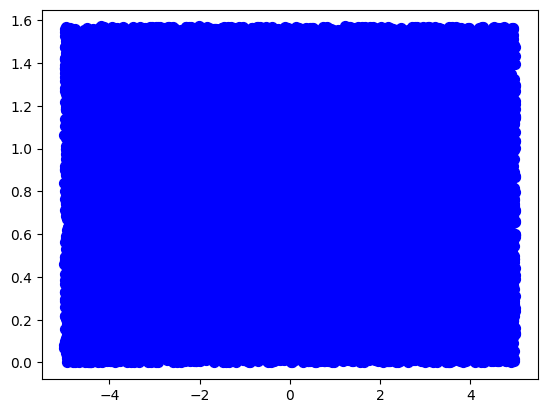

In [11]:
util.print_2d_space(schrodinger_data.collocation_points.detach().cpu())

In [38]:
schrodinger_data.y_train.shape

torch.Size([50, 2])

In [39]:
schrodinger_data.X_low_boundary[:5], schrodinger_data.X_high_boundary[:5]

(tensor([[-5.0000,  0.0634],
         [-5.0000,  1.4638],
         [-5.0000,  0.2390],
         [-5.0000,  0.4163],
         [-5.0000,  0.2049]], dtype=torch.float64, grad_fn=<SliceBackward0>),
 tensor([[5.0000, 0.0634],
         [5.0000, 1.4638],
         [5.0000, 0.2390],
         [5.0000, 0.4163],
         [5.0000, 0.2049]], dtype=torch.float64, grad_fn=<SliceBackward0>))

In [25]:
class SchrodingerModel(nn.Module):
    def __init__(self, n_input: int, n_layer: int, n_out: int):
        super().__init__()
        n_hidden = 100
        self.first = self.block(n_input, n_hidden)
        self.hidden = nn.Sequential(*[self.block(n_hidden, n_hidden) for i in range(n_layer) ])
        self.last = nn.Linear(n_hidden, n_out, dtype=torch.float64)

        self.apply(self._init_weights)

    def block(self, n_input, n_hidden):
        return nn.Sequential(*[
            nn.Linear(n_input, n_hidden, dtype=torch.float64),
            nn.Tanh()
        ])

    def _init_weights(self, module):
        """Apply Xavier initialization to linear layers"""
        if isinstance(module, nn.Linear):
            # Xavier uniform initialization (also called Glorot uniform)
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, X):
        return self.last(self.hidden(self.first(X)))


In [ ]:
epochs = 1000
schrodinger_model = SchrodingerModel(n_input=2,n_layer=3, n_out=2)
optimizer = torch.optim.Adam(schrodinger_model.parameters())
schrodinger_model.to(device)

SchrodingerModel(
  (first): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
  )
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (4): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
  )
  (last): Linear(in_features=100, out_features=2, bias=True)
)

In [27]:
def get_boundary_loss(schrodinger_model, schrodinger_data):
    upper_bound = schrodinger_model(schrodinger_data.X_high_boundary)
    lower_bound = schrodinger_model(schrodinger_data.X_low_boundary)

    u_x_upper = torch.autograd.grad(
        torch.sum(upper_bound[:,0]),
        schrodinger_data.X_high_boundary,
        retain_graph=True,
        create_graph=True
    )[0][:,0]

    v_x_upper = torch.autograd.grad(
        torch.sum(upper_bound[:,1]),
        schrodinger_data.X_high_boundary,
        retain_graph=True,
        create_graph=True
    )[0][:,0]

    u_x_lower = torch.autograd.grad(
        torch.sum(lower_bound[:,0]),
        schrodinger_data.X_low_boundary,
        retain_graph=True,
        create_graph=True
    )[0][:,0]

    v_x_lower = torch.autograd.grad(
        torch.sum(lower_bound[:,1]),
        schrodinger_data.X_low_boundary,
        create_graph=True
    )[0][:,0]

    boundary_loss = (v_x_lower - v_x_upper)**2 + (u_x_lower - u_x_upper)**2
    boundary_loss = torch.mean(boundary_loss)

    return boundary_loss

def get_function_loss(schrodinger_model, schrodinger_data):
    h_collocation = schrodinger_model(schrodinger_data.collocation_points)
    u = h_collocation[:,0]
    v = h_collocation[:,1]

    u_x = torch.autograd.grad(
        torch.sum(u),
        schrodinger_data.collocation_points,
        retain_graph=True,
        create_graph=True
    )[0][:,0]

    u_xx = torch.autograd.grad(
        torch.sum(u_x),
        schrodinger_data.collocation_points,
        retain_graph=True,
        create_graph=True
    )[0][:,0]

    u_t = torch.autograd.grad(
        torch.sum(u),
        schrodinger_data.collocation_points,
        create_graph=True
    )[0][:,1]

    v_x = torch.autograd.grad(
        torch.sum(v),
        schrodinger_data.collocation_points,
        retain_graph=True,
        create_graph=True
    )[0][:,0]

    v_xx = torch.autograd.grad(
        torch.sum(v_x),
        schrodinger_data.collocation_points,
        retain_graph=True,
        create_graph=True
    )[0][:,0]


    v_t = torch.autograd.grad(
        torch.sum(v),
        schrodinger_data.collocation_points,
        create_graph=True
    )[0][:,1]

    f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
    f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u

    return torch.mean(f_u**2) + torch.mean(f_v**2)

def get_loss(schrodinger_model, schrodinger_data):
    data_y = schrodinger_model(schrodinger_data.X_train)
    data_loss = torch.mean((data_y - schrodinger_data.y_train)**2)

    boundary_loss = get_boundary_loss(schrodinger_model, schrodinger_data)
    f_loss = get_function_loss(schrodinger_model, schrodinger_data)


    return data_loss, boundary_loss, f_loss

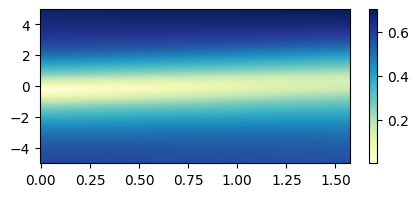

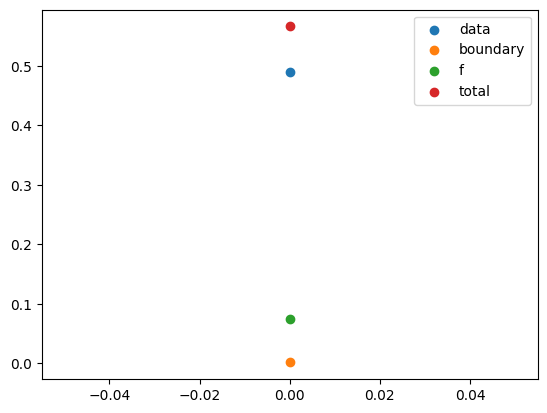

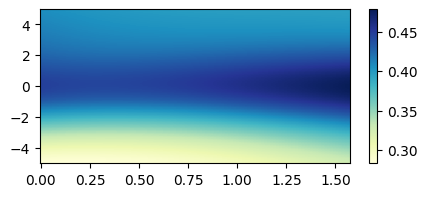

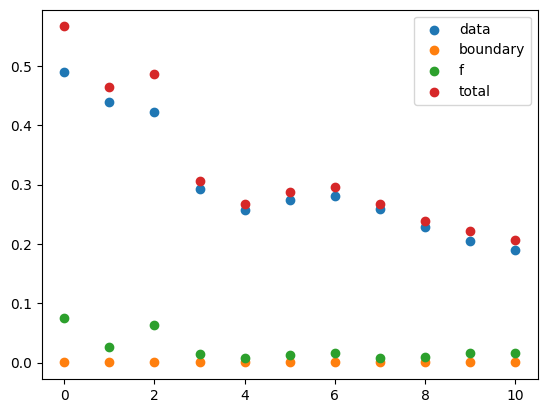

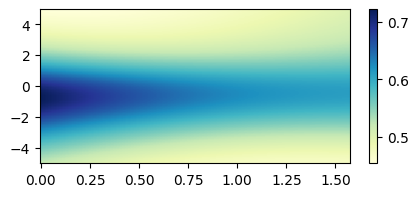

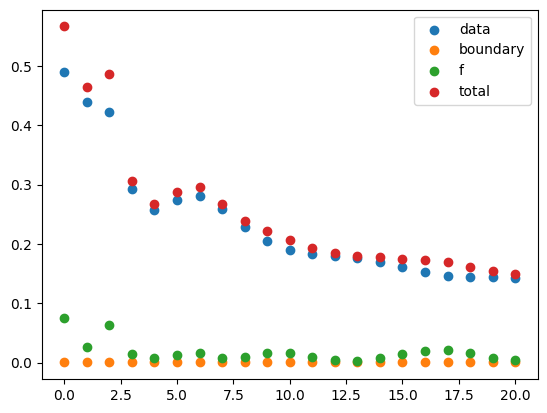

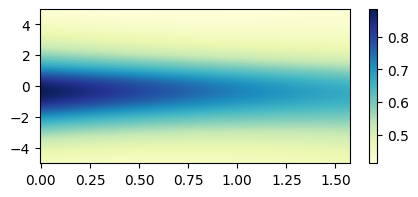

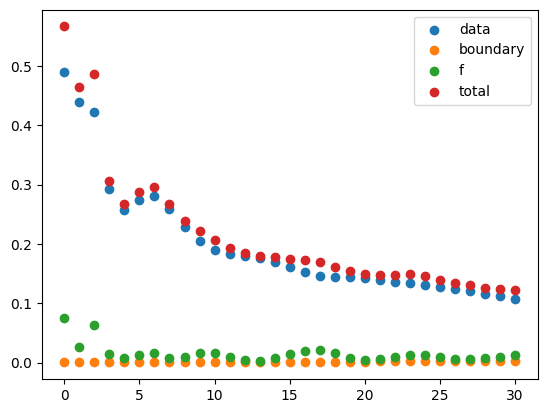

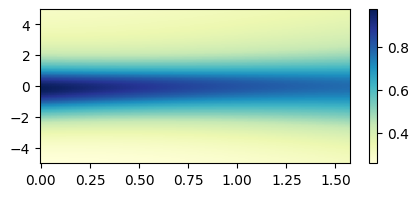

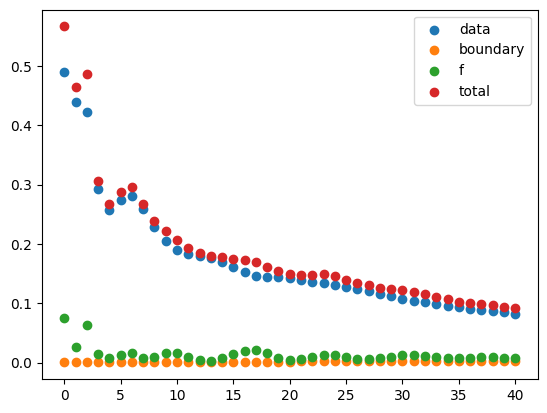

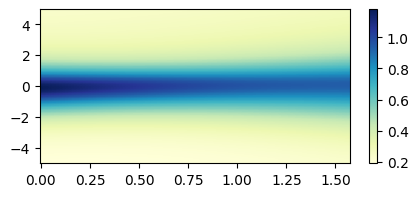

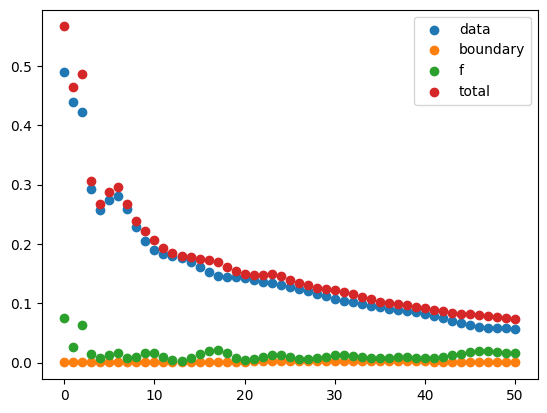

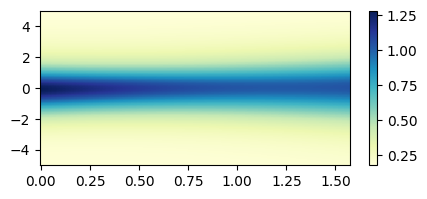

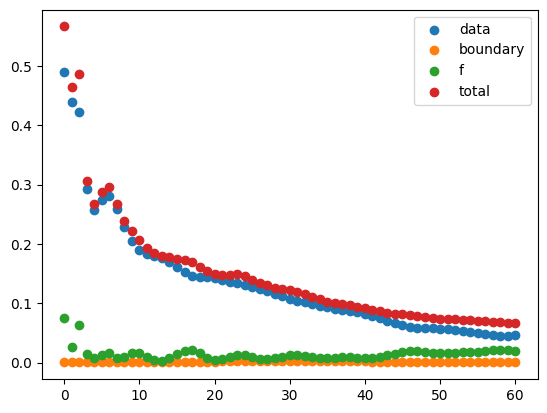

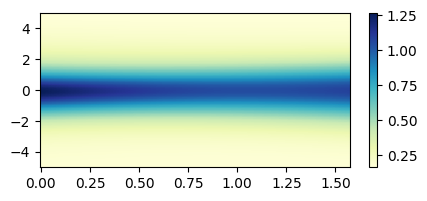

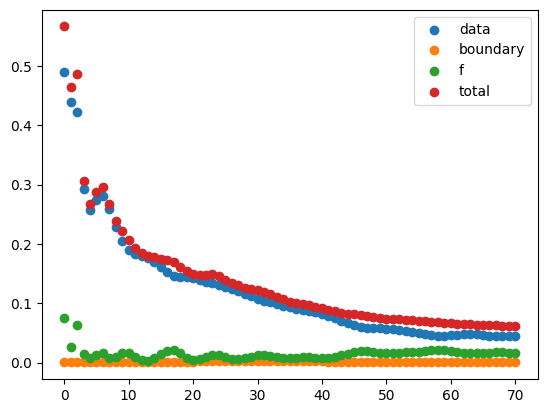

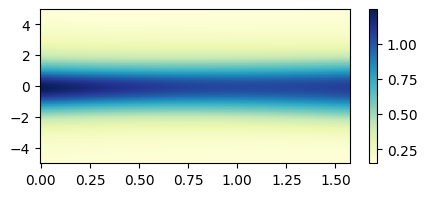

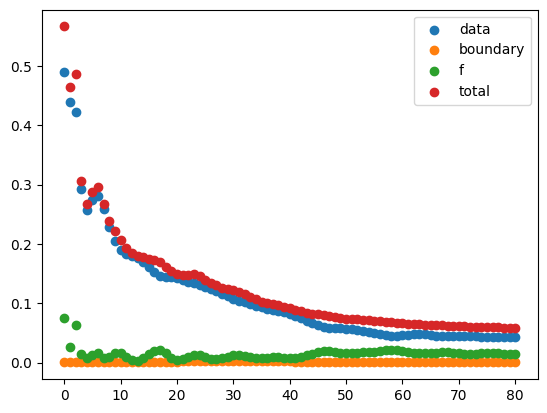

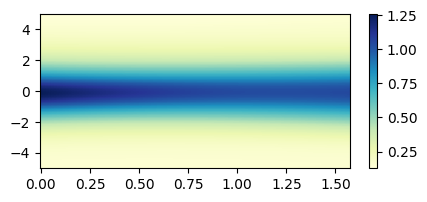

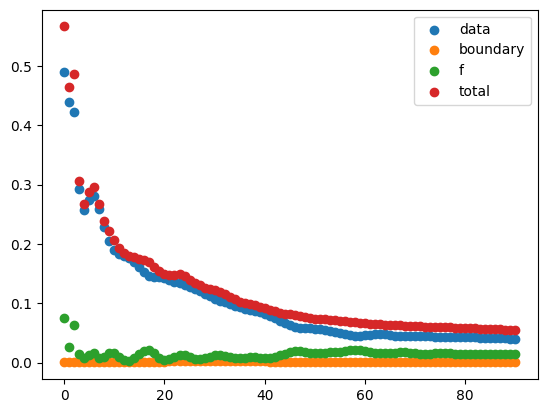

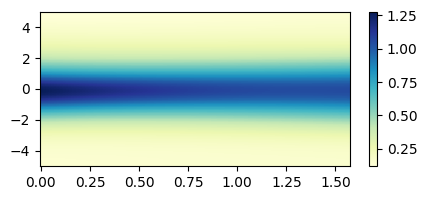

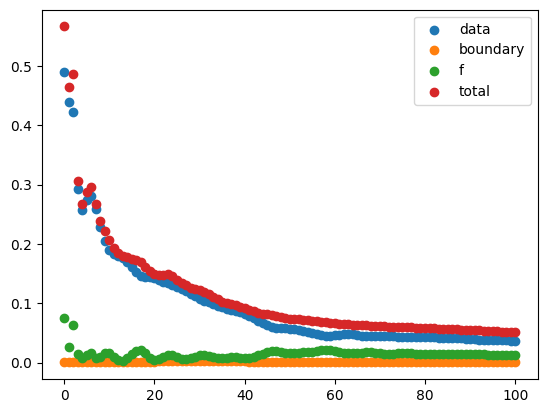

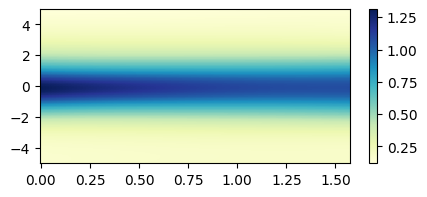

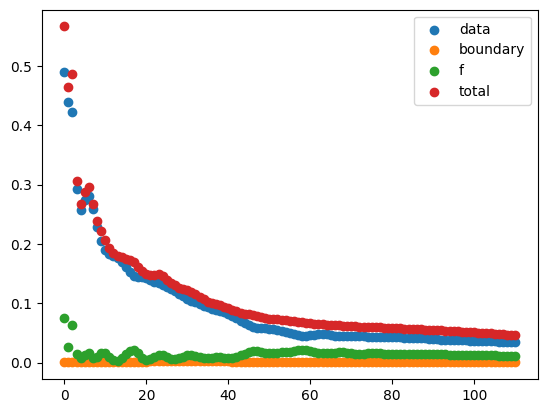

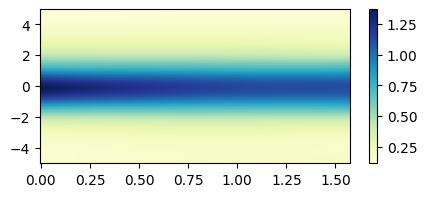

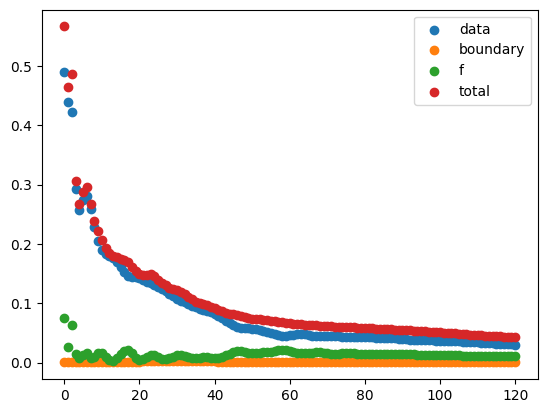

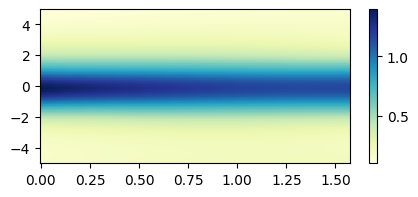

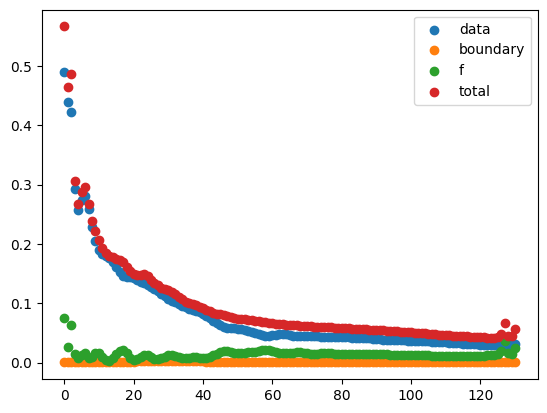

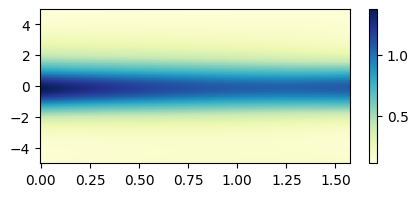

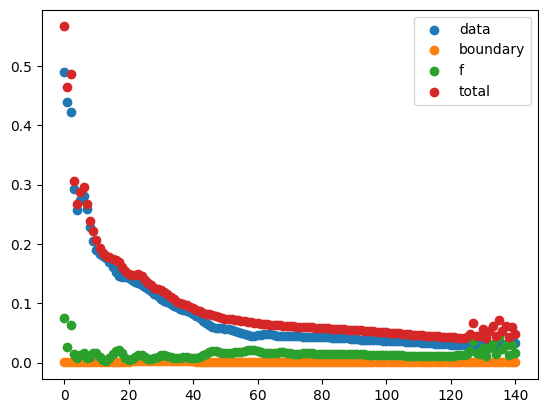

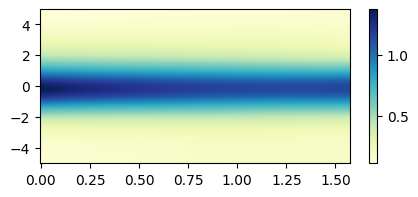

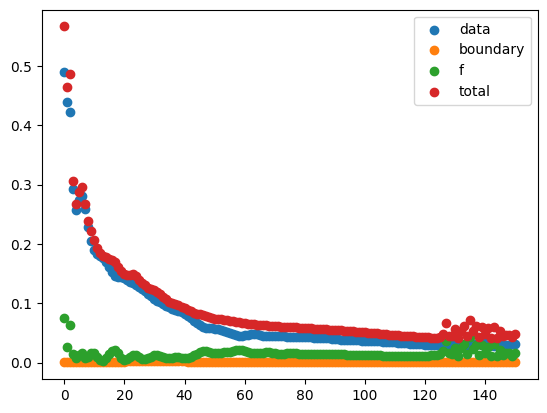

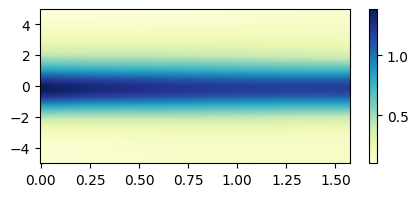

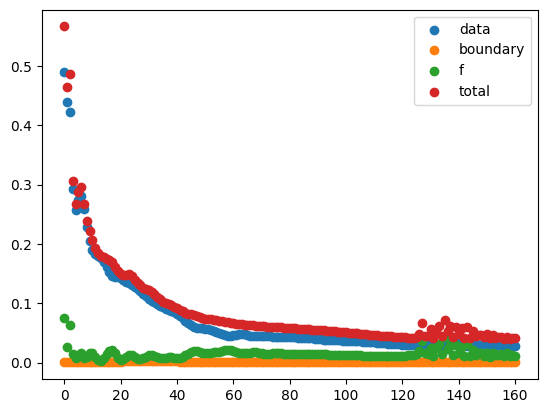

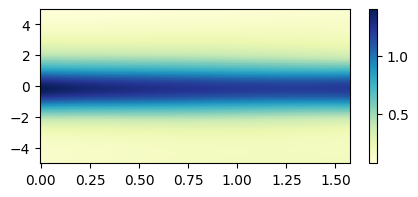

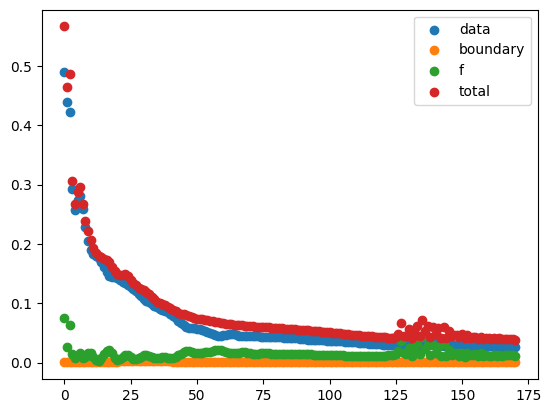

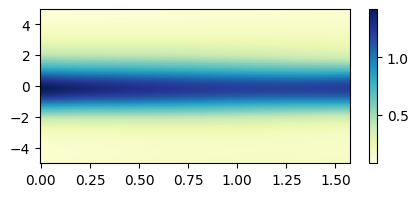

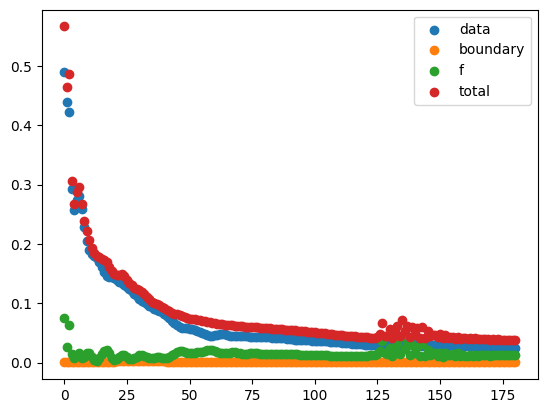

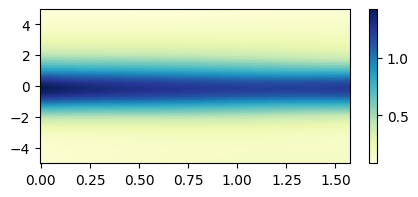

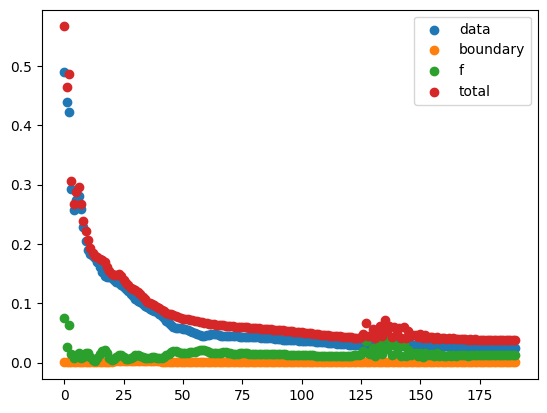

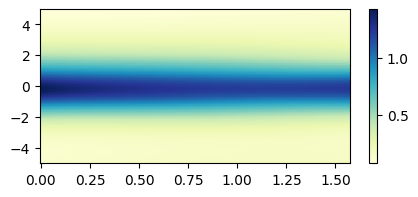

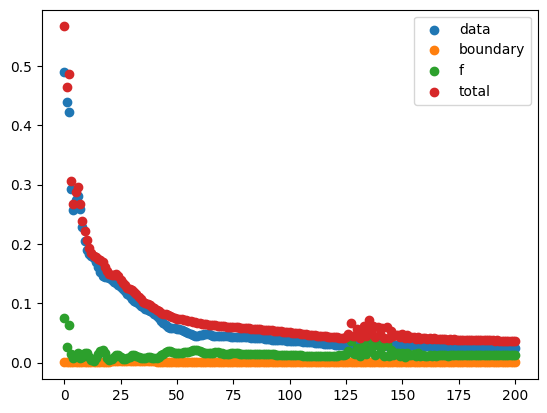

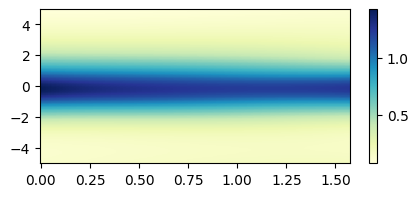

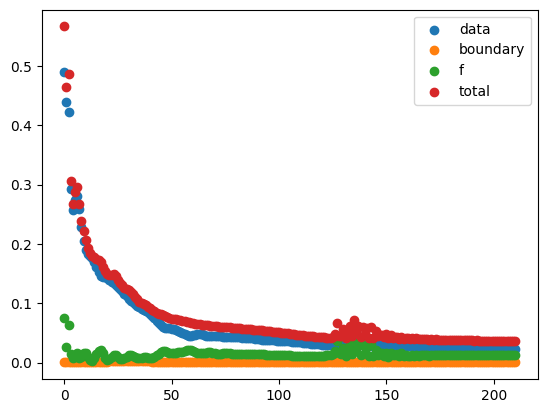

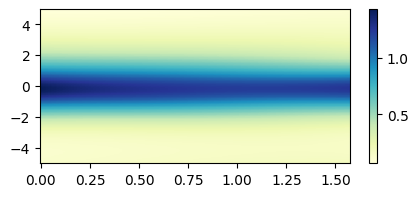

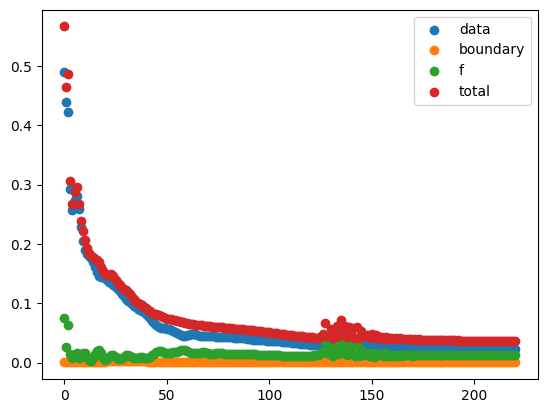

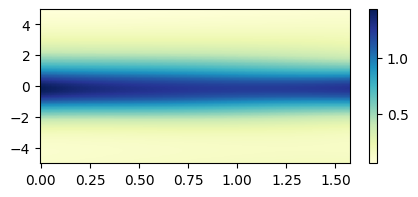

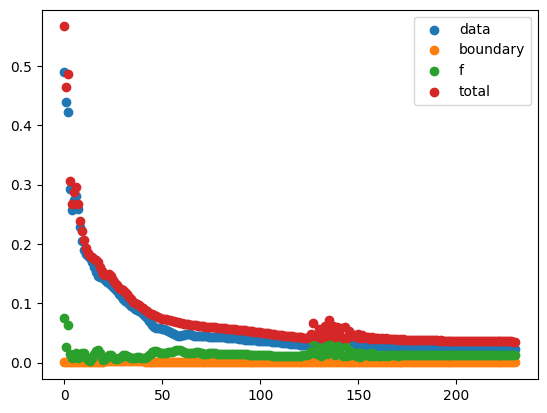

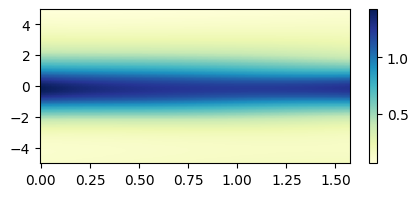

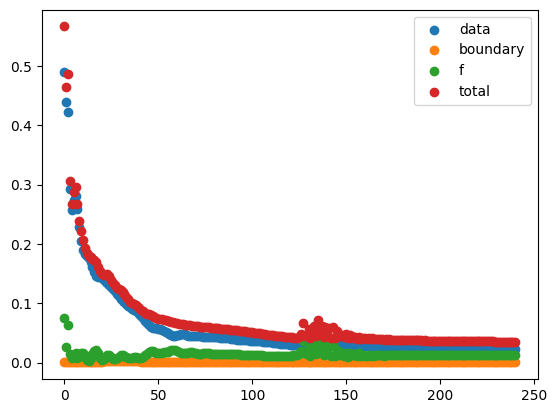

KeyboardInterrupt: 

In [28]:
data_losses = []
boundary_losses = []
f_losses = []
for i in range(epochs):
    optimizer.zero_grad()
    schrodinger_data.X_low_boundary.grad = None
    schrodinger_data.X_high_boundary.grad = None
    schrodinger_data.collocation_points.grad = None

    data_loss, boundary_loss, f_loss = get_loss(schrodinger_model, schrodinger_data)
    loss = data_loss + boundary_loss + f_loss

    loss.backward()

    optimizer.step()

    data_losses.append(data_loss.item())
    boundary_losses.append(boundary_loss.item())
    f_losses.append(f_loss.item())

    if i % (epochs // 100) == 0:
        T_np, X_np = np.meshgrid(t_np.flatten(), x_np.flatten())
        pairs = torch.tensor(np.column_stack([X_np.ravel(), T_np.ravel()]), device=device)

        result = schrodinger_model(pairs)

        np_result = np.abs(result.detach().cpu().numpy()[:,1] * 1j + result.detach().cpu().numpy()[:,0])

        plt.figure(figsize=(5,2))
        plt.pcolormesh(T_np, X_np, np_result.reshape(x_np.shape[0], t_np.shape[0]), cmap="YlGnBu")
        plt.colorbar()
        plt.show()
        plt.scatter(np.arange(len(data_losses)), np.array(data_losses), label="data")
        plt.scatter(np.arange(len(boundary_losses)), np.array(boundary_losses), label="boundary")
        plt.scatter(np.arange(len(f_losses)), np.array(f_losses), label="f")
        plt.scatter(np.arange(len(boundary_losses)), np.array(boundary_losses) + np.array(data_losses) + np.array(f_losses), label="total")
        plt.legend()
        plt.show()





In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive')  # mounts your Drive

# Suppose your model is called 'model' and optimizer 'optimizer'
checkpoint_path = "/content/drive/MyDrive/schrodinger_model.pt"

torch.save({
    'model_state_dict': schrodinger_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 15000,                # optional: last completed epoch
    'loss': (data_losses, boundary_losses, f_losses)                   # optional: last loss
}, checkpoint_path)

print(f"Checkpoint saved to {checkpoint_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint saved to /content/drive/MyDrive/schrodinger_model.pt


In [51]:
epochs = 1

checkpoint_path = "./schrodinger_model-9000.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)

schrodinger_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

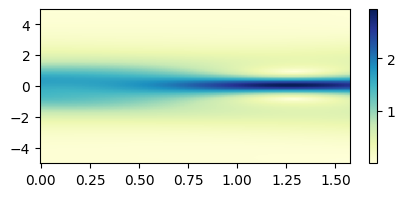

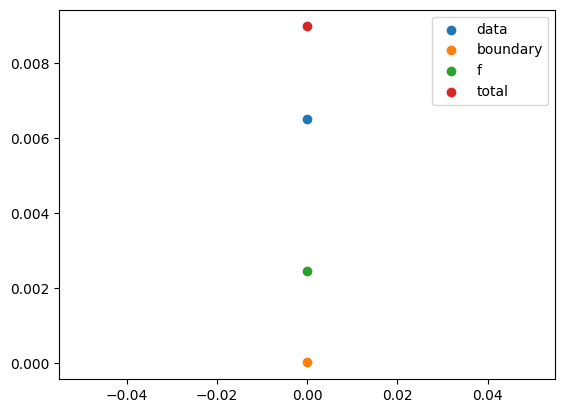

In [52]:
data_losses = []
boundary_losses = []
f_losses = []
for i in range(epochs):
    optimizer.zero_grad()
    schrodinger_data.X_low_boundary.grad = None
    schrodinger_data.X_high_boundary.grad = None
    schrodinger_data.collocation_points.grad = None

    data_loss, boundary_loss, f_loss = get_loss(schrodinger_model, schrodinger_data)
    loss = data_loss + boundary_loss + f_loss

    loss.backward()

    optimizer.step()

    data_losses.append(data_loss.item())
    boundary_losses.append(boundary_loss.item())
    f_losses.append(f_loss.item())

    # if i % (epochs // 100) == 0:
    if True:
        T_np, X_np = np.meshgrid(t_np.flatten(), x_np.flatten())
        pairs = torch.tensor(np.column_stack([X_np.ravel(), T_np.ravel()]), device=device)

        result = schrodinger_model(pairs)

        np_result = np.abs(result.detach().cpu().numpy()[:,1] * 1j + result.detach().cpu().numpy()[:,0])

        plt.figure(figsize=(5,2))
        plt.pcolormesh(T_np, X_np, np_result.reshape(x_np.shape[0], t_np.shape[0]), cmap="YlGnBu")
        plt.colorbar()
        plt.show()
        plt.scatter(np.arange(len(data_losses)), np.array(data_losses), label="data")
        plt.scatter(np.arange(len(boundary_losses)), np.array(boundary_losses), label="boundary")
        plt.scatter(np.arange(len(f_losses)), np.array(f_losses), label="f")
        plt.scatter(np.arange(len(boundary_losses)), np.array(boundary_losses) + np.array(data_losses) + np.array(f_losses), label="total")
        plt.legend()
        plt.show()